Author: Olabode James

PROJECT SCOPE
- Basic understanding of text pre-processing.
- What to do after text pre-processing:
    Bag of words
    Tf-idf
- Build the classification model.
- Evaluate the Model.

# 1. Import the libraries, load dataset, print shape of data, data description. (5 Marks)

In [1]:
#Dependencies - if not available
!pip install contractions
#!pip install xgboost

In [2]:
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True) # adds a nice background to the graphs

from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.


# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#Classification Algorithms and Functions

from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#DeepLearning Using 1D ConvNet
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.metrics import confusion_matrix

### Import PyDrive and Google Drive Libraries

In [4]:
# Google Drive Accessibility libraries
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

#### NOTE: PyDrive and GDrive Libraries is being used out of the need to use Link Shareable Files in this project - the author believe this is more scaleable than the standard content mount procedure - need to keep a persistent state.

In [5]:
tweets_link = 'https://drive.google.com/file/d/1kVMjOHrqP_SH47Pz5L_lvsgGmtn-_8ey/view?usp=sharing' # The shareable link

In [6]:
def getShareableID(datalocation):
  fluff, id = datalocation.split('/view')
  fluff1, id1 = fluff.split('d/')
  return id1

In [7]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
#Fetch Tweet Data
tweets_id = getShareableID(tweets_link)
print(tweets_id) # Verify that WE have right id fromt the string manipulation

1kVMjOHrqP_SH47Pz5L_lvsgGmtn-_8ey


In [9]:
tweetsdata = drive.CreateFile({'id':tweets_id}) 
tweetsdata.GetContentFile('Tweets.csv')  
tweetsdata = pd.read_csv('Tweets.csv')

In [10]:
#check shape of tweets data
tweetsdata.shape

(14640, 15)

In [11]:
tweetsdata.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [12]:
tweetsdata['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [13]:
tweetsdata['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Some EDA to have a feel for the data, nature of sentiments contained in the data

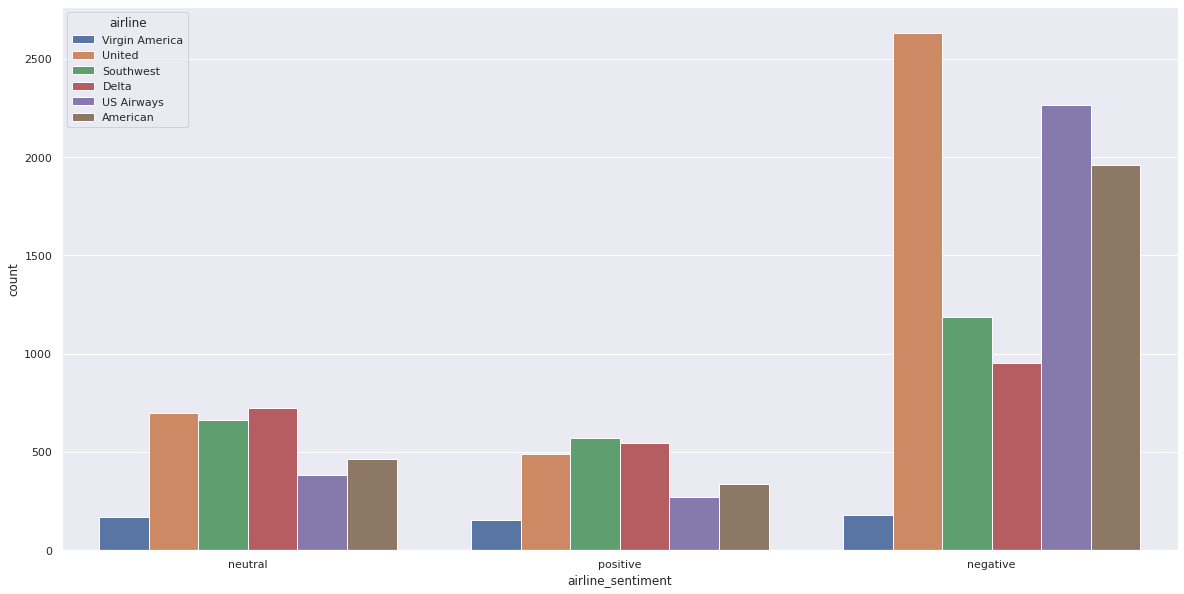

In [14]:
plt.figure(figsize=(20,10))
sns.countplot(tweetsdata['airline_sentiment'], hue=tweetsdata['airline']);

INSIGHT: Large number of negative feedbacks, with United leading the pack on negatives, third on positives and second on neutral. Seems most folk are angry with travel experience during the period under review.

# 2. Understand of data-columns: (5 Marks)
      a. Drop all other columns except “text” and “airline_sentiment”.
      b. Check the shape of data.
      c. Print first 5 rows of data

In [15]:
# Fetching data for purpose of analysis
# Only keeping airline_sentiment and text columns from the data, as these are useful for our analysis.

sentimentsdata = tweetsdata.loc[:, ['airline_sentiment', 'text']]

In [16]:
sentimentsdata.isnull().sum(axis=0)                                # Check for NULL values.

airline_sentiment    0
text                 0
dtype: int64

No Null data, moving on

In [17]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)
sentimentsdata.head()                       # Check first 5 rows of data

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [18]:
sentimentsdata.shape    

(14640, 2)

# 3. Text pre-processing: Data preparation. (20 Marks)
    a. Html tag removal.
    b. Tokenization.
    c. Remove the numbers.
    d. Removal of Special Characters and Punctuations.
    e. Conversion to lowercase.
    f. Lemmatize or stemming.
    g. Join the words in the list to convert back to text string in the dataframe. (So that each row contains the data in text format.)
    h. Print first 5 rows of data after pre-processing.

In [19]:
#A. First order of business on pre-processing - removing all html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

sentimentsdata['text'] = sentimentsdata['text'].apply(lambda x: strip_html(x))
sentimentsdata.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [20]:
# Handling contractions which are common in written social media posts and feedback so no meaning is lost
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

sentimentsdata['text'] = sentimentsdata['text'].apply(lambda x: replace_contractions(x))
sentimentsdata.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


INSIGHT: Contractions dealth with - Can see improvement - "didn't" changed to "did not" as expected.

In [21]:
#C. Step 3 removing numbers
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

sentimentsdata['text'] = sentimentsdata['text'].apply(lambda x: remove_numbers(x))
sentimentsdata.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [22]:
#Next step is Tokenization to make next steps of pre-processing easy
sentimentsdata['text'] = sentimentsdata.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

In [23]:
sentimentsdata.head()                                                                    # Look at how tokenized data looks.

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


DEDUCTION: Expected results obtained - text data have been tokenized which will make next steps of preprocessing successful

In [24]:
# Our special list of stop words - custom stop-word's list as not, couldn't etc. words matter in Sentiment, 
# so not removing them from original data.
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

stopwords = list(set(stopwords) - set(customlist))  

In [25]:
#Creating a suite of functions to handle Special Characters and Punctuations, lower case, punctuation removal, 
# stopwords, lemmatization and normalization and join everything back together

lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

sentimentsdata['text'] = sentimentsdata.apply(lambda row: normalize(row['text']), axis=1)
sentimentsdata.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


DEDUCTION: Data preprocessing is now successful - expected results obtained

# 4. Vectorization: (10 Marks)
    a. Use CountVectorizer.
    b. Use TfidfVectorizer

In [26]:
#USING CountVectorizer - applying unigram and bigram extraction through the ngram argument
countVectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))               # GOOD PRACTICE: Keep only 1000 features as number of features will increase the processing time.
count_data_features = countVectorizer.fit_transform(sentimentsdata['text'])

count_data_features = count_data_features.toarray()

In [27]:
count_data_features.shape

(14640, 1000)

In [28]:
#USING TFIDVectorizer - 
tfidVectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
# tokenize and build vocab
tfidVectorizer.fit(sentimentsdata['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [29]:
# summarize
print(tfidVectorizer.vocabulary_)
print(tfidVectorizer.idf_)

{'virginamerica': 942, 'say': 742, 'plus': 662, 'add': 9, 'experience': 272, 'not': 582, 'today': 860, 'must': 558, 'mean': 522, 'need': 562, 'take': 832, 'another': 45, 'trip': 872, 'really': 695, 'little': 492, 'big': 94, 'bad': 82, 'thing': 848, 'seriously': 755, 'would': 983, 'pay': 642, 'flight': 304, 'seat': 746, 'play': 658, 'fly': 330, 'yes': 995, 'every': 263, 'time': 856, 'go': 372, 'away': 77, 'every time': 264, 'time fly': 857, 'not go': 594, 'miss': 544, 'without': 970, 'https': 426, 'well': 963, 'amaze': 27, 'arrive': 63, 'hour': 414, 'early': 245, 'good': 375, 'know': 460, 'second': 747, 'pretty': 672, 'much': 556, 'better': 92, 'great': 376, 'deal': 208, 'already': 24, 'think': 850, 'nd': 561, 'even': 260, 'st': 800, 'yet': 997, 'not even': 589, 'travel': 870, 'http': 425, 'thank': 843, 'virginamerica thank': 943, 'schedule': 744, 'still': 811, 'mia': 532, 'excite': 269, 'first': 295, 'cross': 192, 'country': 185, 'lax': 472, 'mco': 521, 'hear': 393, 'nothing': 611, 'th

In [30]:
# encode data
#vector = tfidVectorizer.transform([text[0]])
vector = tfidVectorizer.transform(sentimentsdata['text'])

# summarize encoded vector
tfid_data_features = vector.toarray()
print(vector.shape)
print(tfid_data_features)

(14640, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [31]:
# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])

In [32]:
#We need to extract our labels in desired format 

#labels = sentimentsdata['airline_sentiment']
#labels = labels.astype('int')

In [33]:
# label_encoder object knows how to understand word labels - like neutral, negative and positive
label_encoder = preprocessing.LabelEncoder() 
# Encode labels in column 'airline_sentiment'. 
labels = label_encoder.fit_transform(sentimentsdata['airline_sentiment']) 

In [34]:
labels.dtype

dtype('int64')

In [35]:
labels

array([1, 2, 1, ..., 1, 0, 1])

# 5. Fit and evaluate model using both type of vectorization. (6+6 Marks)

### Count Vectorizer - Fit and Evaluate model

In [36]:
#Fitting and evaluating the Count Vectorizer data
X_train, X_test, y_train, y_test = train_test_split(count_data_features, labels, test_size=0.3, random_state=42)

In [37]:
#Creating the Basic Conv1D Model for passage to the classifier

Conv1Model = Sequential()
Conv1Model.add(Conv1D(64, 3, activation="relu", input_shape=(1000,1)))
Conv1Model.add(Dense(16, activation="relu"))
Conv1Model.add(MaxPooling1D())
Conv1Model.add(Flatten())
Conv1Model.add(Dense(3, activation = 'softmax'))
Conv1Model.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "adam",               
              metrics = ['accuracy'])
Conv1Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 998, 64)           256       
_________________________________________________________________
dense (Dense)                (None, 998, 16)           1040      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 499, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7984)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 23955     
Total params: 25,251
Trainable params: 25,251
Non-trainable params: 0
_________________________________________________________________


In [38]:
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200, n_jobs=4), 
    XGBClassifier()]

Predicting Sentiment from Tweetdata using - 
  1. DecisionTreeClassifier
  2. RandomForestClassifier
  3. XGBoost Classifier
  4. Conv1D Classifier - LSTM

CountVectorizer: Accuracy of DecisionTreeClassifier is 69.97%
              precision    recall  f1-score   support

    Negative       0.79      0.82      0.80      2721
     Neutral       0.50      0.45      0.47      1001
    Positive       0.59      0.61      0.60       670

    accuracy                           0.70      4392
   macro avg       0.63      0.62      0.62      4392
weighted avg       0.69      0.70      0.70      4392



<Figure size 432x288 with 0 Axes>

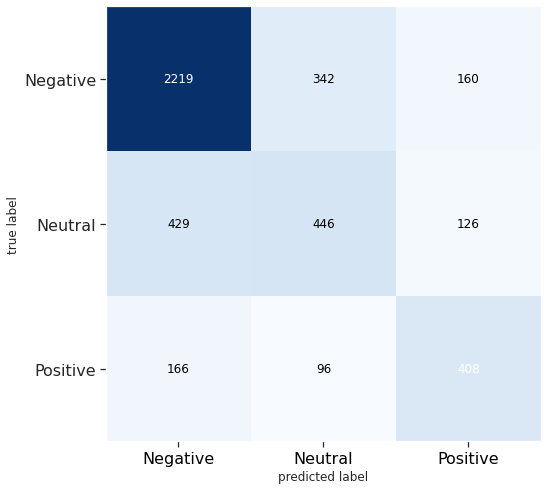

CountVectorizer: Accuracy of RandomForestClassifier is 76.73%
              precision    recall  f1-score   support

    Negative       0.89      0.83      0.86      3032
     Neutral       0.49      0.58      0.53       759
    Positive       0.61      0.71      0.65       601

    accuracy                           0.77      4392
   macro avg       0.67      0.70      0.68      4392
weighted avg       0.78      0.77      0.77      4392



<Figure size 432x288 with 0 Axes>

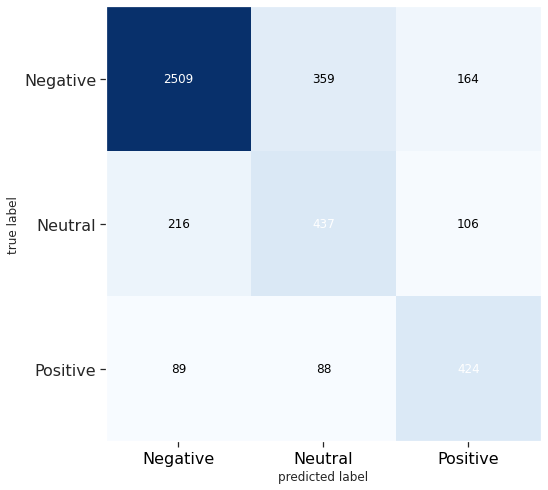

CountVectorizer: Accuracy of XGBClassifier is 73.84%
              precision    recall  f1-score   support

    Negative       0.96      0.74      0.84      3659
     Neutral       0.18      0.76      0.30       214
    Positive       0.54      0.72      0.62       519

    accuracy                           0.74      4392
   macro avg       0.56      0.74      0.58      4392
weighted avg       0.87      0.74      0.78      4392



<Figure size 432x288 with 0 Axes>

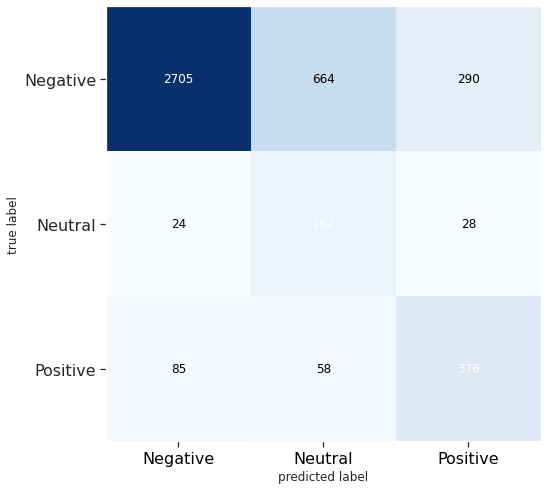

In [39]:
Accuracy=[]
Model=[]
labelsNames = ['Negative', 'Neutral', 'Positive']
for classifier in Classifiers:
    try:
        fit = classifier.fit(X_train,y_train)
        pred = fit.predict(X_test)
    except Exception:
        fit = classifier.fit(X_train,y_train)
        pred = fit.predict(X_test)
    accuracy = accuracy_score(pred,y_test)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('CountVectorizer: Accuracy of '+classifier.__class__.__name__+ " is %.2f%%" % (accuracy * 100.0))
    print(classification_report(pred,y_test,target_names=labelsNames))
    cm = confusion_matrix(pred , y_test)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
    plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16, color='black')
    plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
    plt.show()

In [40]:
#Conv1Model.fit(X_train, y_train, batch_size=16,epochs=100, verbose=0)

#acc = Conv1Model.evaluate(X_train, y_train)
#print("Loss:", acc[0], " Accuracy:", acc[1])

#pred = Conv1Model.predict(X_test)
#pred_y = pred.argmax(axis=-1)

#cm = confusion_matrix(y_test, pred_y)
#print(cm)

### TFID Vectorizer - Fit and Evaluate model

In [41]:
#Fitting and evaluating the Count Vectorizer data
X_train, X_test, y_train, y_test = train_test_split(tfid_data_features, labels, test_size=0.3, random_state=42)

TFIDVectorizer: Accuracy of DecisionTreeClassifier is 68.74%
              precision    recall  f1-score   support

    Negative       0.79      0.80      0.80      2772
     Neutral       0.49      0.45      0.47       980
    Positive       0.51      0.55      0.53       640

    accuracy                           0.69      4392
   macro avg       0.60      0.60      0.60      4392
weighted avg       0.68      0.69      0.69      4392



<Figure size 432x288 with 0 Axes>

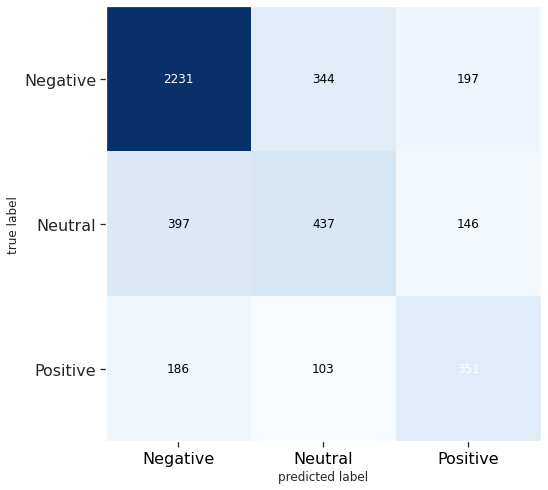

TFIDVectorizer: Accuracy of RandomForestClassifier is 77.21%
              precision    recall  f1-score   support

    Negative       0.92      0.81      0.86      3197
     Neutral       0.46      0.61      0.52       667
    Positive       0.57      0.75      0.65       528

    accuracy                           0.77      4392
   macro avg       0.65      0.72      0.68      4392
weighted avg       0.81      0.77      0.78      4392



<Figure size 432x288 with 0 Axes>

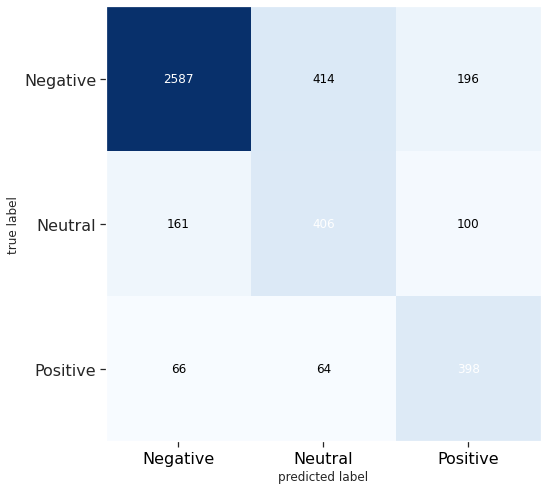

TFIDVectorizer: Accuracy of XGBClassifier is 75.43%
              precision    recall  f1-score   support

    Negative       0.94      0.78      0.85      3421
     Neutral       0.33      0.62      0.43       469
    Positive       0.53      0.74      0.62       502

    accuracy                           0.75      4392
   macro avg       0.60      0.71      0.63      4392
weighted avg       0.83      0.75      0.78      4392



<Figure size 432x288 with 0 Axes>

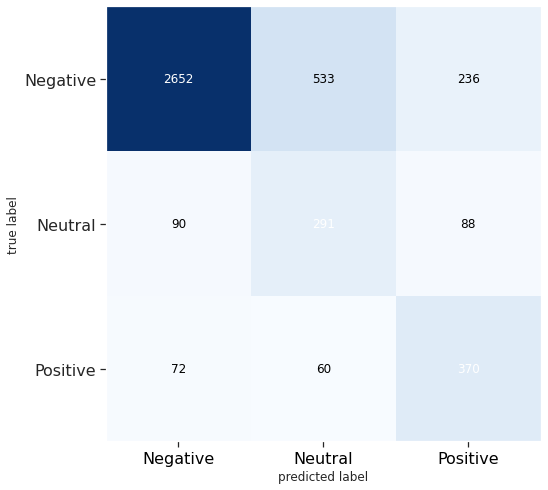

In [42]:
Accuracy=[]
Model=[]
labelsNames = ['Negative', 'Neutral', 'Positive']
for classifier in Classifiers:
    try:
        fit = classifier.fit(X_train,y_train)
        pred = fit.predict(X_test)
    except Exception:
        fit = classifier.fit(X_train,y_train)
        pred = fit.predict(X_test)
    accuracy = accuracy_score(pred,y_test)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('TFIDVectorizer: Accuracy of '+classifier.__class__.__name__+ " is %.2f%%" % (accuracy * 100.0))
    print(classification_report(pred,y_test,target_names=labelsNames))
    cm = confusion_matrix(pred , y_test)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
    plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16, color='black')
    plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
    plt.show()

# 6. Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset. (8 Marks)

Conclusion: Pre-processing is fundamental to building good predictive models for Natural Language Machine Learning Task. 

As computers do not understand human language, adequate preparation of the data before being fed into the machine learning model is extreme important.

Generally, the choice of process for pre-processing is dependent on the scope of the Text classification or Sentiment analysis task.

The steps to follow can be:

1. Html tag removal.
2. Tokenization.
3. Remove the numbers.
4. Removal of Special Characters and Punctuations.
5. Conversion to lowercase.
6. Lemmatize or stemming.


Careful treatment of Stopwords, vis-a-vis their removal or not is important to effective sentiment analysis. In this project, care was taken to implement a custom stop words treatment so not to result in poor performance of the prediction models on negative sentiments. Thus, the various ML models used performed close very well in predicting negative sentiment as a result.

Also, because dataset is from social media - lemmatization helped in ensuring the root word is not lost during preprocessing - and also to ensure words are mapped to correct form especially on the prevalence need to always shorten spellings on social media platform.

In this project, CountVectorizer and TFIDVectorizers where used to process the input data. 


Unigram and bigrams were extracted through the ngram_range argument, this resulted in slight improvement in performance.

The difference in result was evident - TFIDVectorizer gave better accuracy, precision, recall and f1_score on the input data over all the ML model used, compared to CountVectorizer. This is attributable to the architecture of words and inferences deductible

1. TFIDVectorizer - TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

2. CountVectorizer - which is used to transform a corpora of text to a vector of term / token counts. 

Conclusively, a count of words did not give better predictive potential to word importance-frequence especially in text classifications with attention on sentiments.

Also, the pre-processing steps seems to have enhanced the capacity of the various models to predict negative sentiments better than positive sentiments, however all ML models performed poorly on neutral sentiments even though it was second highest sentiment in the dataset.

While a higher performance was seen on negative sentiments, this may be connected to a larger datasets on negative sentiments compared to others sentiment types.

Next steps and conclusion, striving for higher accuracy on positive and neutral sentiment will improve the overall performance of the models even better.